In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


# Loading dataset

In [48]:
data_path = "data/playground_data.csv"

In [49]:
df_model = pd.read_csv(data_path).fillna("")

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [7]:
# Candidate covariates; we keep the ones that exist in df
candidate_covars = ["cmpl_complex", "cmpl_anim", "cmpl_det", "cmpl_def", "cmpl_indiv", "motion_type"]

# Encoding important variables

In [13]:
# Ensure key columns exist
for col in ["cmpl_constr", "book_scroll", "lex"]:
    assert col in df_model.columns, f"Missing column: {col}"

In [14]:
# --- Encode outcome as categorical (no special reference; sum-to-zero)
df_model["cmpl_constr"] = df_model["cmpl_constr"].astype("category")
class_labels = df_model["cmpl_constr"].cat.categories.tolist()
K = len(class_labels)
y = df_model["cmpl_constr"].cat.codes.values  # 0..K-1

In [17]:
# --- Encode grouping factors as categorical indices
df_model["book_scroll"] = df_model["book_scroll"].astype("category")
df_model["lex"] = df_model["lex"].astype("category")

In [18]:
book_labels = df_model["book_scroll"].cat.categories.tolist()
verb_labels = df_model["lex"].cat.categories.tolist()
B = len(book_labels)
V = len(verb_labels)

In [19]:
book_idx = df_model["book_scroll"].cat.codes.values.astype("int32")
verb_idx = df_model["lex"].cat.codes.values.astype("int32")

In [20]:
# --- Build design matrix X for covariates
have_covars = [c for c in candidate_covars if c in df_model.columns]
X_df_parts = []

for c in have_covars:
    s = df_model[c]
    # treat as categorical/boolean
    s = s.astype("category")
    dummies = pd.get_dummies(s, prefix=c, drop_first=True)  # baseline within this covariate
    if dummies.shape[1] > 0:
        X_df_parts.append(dummies.astype(float))

In [21]:
if len(X_df_parts) > 0:
    X_df = pd.concat(X_df_parts, axis=1)
    # Ensure no all-NA or all-constant columns slipped in
    X_df = X_df.loc[:, X_df.apply(lambda col: col.nunique(dropna=True) > 1)]
else:
    # If no covariates present, create a zero-column matrix safely
    X_df = pd.DataFrame(index=df_model.index)

In [22]:
#X_df

In [23]:
[name for name in X_df.columns if name.startswith("cmpl_indiv")]

['cmpl_indiv_adv',
 'cmpl_indiv_nmpr',
 'cmpl_indiv_ppde',
 'cmpl_indiv_ppin',
 'cmpl_indiv_prsf',
 'cmpl_indiv_ptcl',
 'cmpl_indiv_subs']

In [24]:
feature_names = X_df.columns.tolist()
P = len(feature_names)

X = X_df.to_numpy(dtype=float)

N = len(df_model)

print(f"N={N}, K={K} classes, B={B} book_scroll levels, V={V} verb levels, P={P} features")

N=4109, K=4 classes, B=158 book_scroll levels, V=47 verb levels, P=13 features


In [25]:
# ===== 2) Build & fit the PyMC model (sum-to-zero logits) =====
coords = {
    "obs": np.arange(N),
    "class": class_labels,
    "book": book_labels,
    "verb": verb_labels,
    "feature": feature_names,
}

In [26]:
feature_names

['cmpl_complex_simple',
 'cmpl_anim_anim',
 'cmpl_anim_anim inanim',
 'cmpl_anim_inanim',
 'cmpl_det_und',
 'cmpl_indiv_adv',
 'cmpl_indiv_nmpr',
 'cmpl_indiv_ppde',
 'cmpl_indiv_ppin',
 'cmpl_indiv_prsf',
 'cmpl_indiv_ptcl',
 'cmpl_indiv_subs',
 'motion_type_fictive']

# Hierarchical Model - Beta Distribution

In [41]:
with pm.Model(coords=coords) as model:
    # Data containers (easy swapping for PPC / newdata later)
    y_data       = pm.Data("y_data", y, dims="obs")
    book_idx_dat = pm.Data("book_idx", book_idx, dims="obs")
    verb_idx_dat = pm.Data("verb_idx", verb_idx, dims="obs")
    X_dat        = pm.Data("X", X, dims=("obs","feature")) if P > 0 else None

    # --- Intercepts for ALL K classes (no reference class)
    alpha = pm.Beta("alpha", 1.0, 1.0, dims="class")
    alpha_logit = pm.Deterministic("alpha_logit", pm.logit(alpha), dims="class")

    # --- Fixed effects per class (shape: P x K)
    beta = pm.Beta("beta", 1.0, 1.0, dims=("feature","class"))
    beta_logit = pm.Deterministic("beta_logit", pm.logit(beta), dims="class")

    # --- Random intercepts: book_scroll (non-centered), per class ==> effect of the book
    
    sigma_book = pm.HalfNormal("sigma_book", 1.0, dims="class") # how books impact classes (cmpl_constr)
    z_book = pm.Beta("z_book", 1.0, 1.0, dims=("class","book")) # how each book impacts classes (cmpl_constr)
    z_book_logit = pm.Deterministic("z_book_logit", pm.logit(z_book), dims=("class","book"))
    book_eff = pm.Deterministic("book_eff", z_book_logit * sigma_book[:, None], dims=("class","book"))  # K x B
    
    # sigma_book attenuate the effect of z_book; if, for one class, books have no impact or little impact 
    # but one particular book could have an impact
    # the effect of the book in particular is attenuated
    # it attenuates the effect of a specific book that could be random or due to another cause
    # book_eff is the effect of each book on the classes (cmpl_constr)

    # --- Random intercepts: verb (non-centered), per class ==> effect of the verb
    sigma_verb = pm.HalfNormal("sigma_verb", 1.0, dims="class") # how verbs impact classes (cmpl_constr)
    z_verb = pm.Beta("z_verb", 1.0, 1.0, dims=("class","verb")) # how each verb impacts classes (cmpl_constr)
    z_verb_logit = pm.Deterministic("z_verb_logit", pm.logit(z_verb), dims=("class","verb"))
    verb_eff = pm.Deterministic("verb_eff", z_verb_logit * sigma_verb[:, None], dims=("class","verb"))  # K x B

    # --- Linear predictor for all K classes
    # shapes:
    #   alpha          : (K,) -> (N,K) after broadcasting
    #   book_eff.T[idx]: (N,K)
    #   verb_eff.T[idx]: (N,K)
    #   X @ beta       : (N,P)@(P,K) -> (N,K), or zeros if P==0

    # This is where the crossed factor choice is implemented (contri and eta)
    # the book_scrolls effect and the verb effect are included at the same time
    # they don't depend on each other (e.g. the book does not change the verb)
    # every observation is classified independently by both factors
    
    book_contrib = pt.transpose(book_eff)[book_idx_dat, :]   # (N, K)
    verb_contrib = pt.transpose(verb_eff)[verb_idx_dat, :]   # (N, K)
    fixed_contrib = pt.dot(X_dat, beta_logit) if P > 0 else pt.zeros((N, K))

    # book_contrib is the contribution o the book on each observation
    # fixed_contrib is the effect of the features on each observation

    # Add alpha (random intercept for the classes) to the contributions

    eta = alpha_logit[None, :] + book_contrib + verb_contrib + fixed_contrib  # (N, K)

    # --- Sum-to-zero constraint across classes for each observation (identifiability)
    eta_centered = eta - pt.mean(eta, axis=1, keepdims=True)  # (N, K)
    # ==> more readable, has no impact on the results probabilities

    # --- Softmax probabilities and likelihood
    p = pm.math.softmax(eta_centered, axis=1)  # (N, K)
    y_obs = pm.Categorical("y_obs", p=p, observed=y_data, dims="obs")
    # ==> transforms logits into probabilities

    # --- Sampling
    idata = pm.sample(
        draws=1000, # I reduced from 2000 to 1000 because of memory issues
        tune=1000, # same here
        chains=4,
        target_accept=0.9,
        random_seed=42,
        cores=None,  # let PyMC decide
    )

    # Posterior predictive
    ppc = pm.sample_posterior_predictive(idata, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_book, z_book, sigma_verb, z_verb]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 710 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

In [43]:
# ===== 3) Basic diagnostics & examples =====
s = az.summary(idata, var_names=["alpha_logit","sigma_book","sigma_verb"], round_to=2)
s
# mean column: the posterior mean of the parameter, expected value under the posterior distribution
# mean tells the average posterior estimate of the variation for the book or verb for each class

# sigma_books: how much book_scrolls differ from each other 
# in their baseline preference for that outcome class

# The next line shows only the rows where an effect is detected (0 present in the HDI)

s[((s["hdi_3%"] < 0) & (s["hdi_97%"] < 0)) | ((s["hdi_3%"] > 0) & (s["hdi_97%"] > 0))]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_logit[1],3.58,1.77,0.40,6.82,0.03,0.03,3677.30,2790.53,1.00
sigma_book[dir-he],0.48,0.14,0.23,0.75,0.00,0.00,807.81,740.99,1.00
sigma_book[prep],0.35,0.12,0.12,0.59,0.01,0.00,565.95,523.89,1.01
sigma_book[vc],0.49,0.12,0.28,0.71,0.00,0.00,923.66,1085.08,1.00
sigma_verb[dir-he],0.50,0.20,0.15,0.90,0.01,0.00,663.42,413.25,1.01
sigma_verb[prep],0.57,0.20,0.19,0.95,0.01,0.00,666.03,754.19,1.01


In [44]:
# Summary of the effect of verbs

s = az.summary(idata, var_names=["verb_eff"], round_to=2)
s
#s[((s["hdi_3%"] < 0) & (s["hdi_97%"] < 0)) | ((s["hdi_3%"] > 0) & (s["hdi_97%"] > 0))]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"verb_eff[dir-he, <BR[]",0.69,0.49,-0.19,1.61,0.01,0.01,1683.06,3498.04,1.00
"verb_eff[dir-he, <LH[]",-0.20,0.39,-0.98,0.49,0.01,0.01,2366.48,2590.98,1.00
"verb_eff[dir-he, <WP[]",-0.01,1.00,-1.90,2.00,0.01,0.03,8741.69,2783.89,1.00
"verb_eff[dir-he, <WZ[]",-0.08,0.92,-1.95,1.68,0.01,0.02,8797.38,2644.00,1.00
"verb_eff[dir-he, >TH[]",-0.02,0.95,-1.99,1.72,0.01,0.02,8536.48,3032.85,1.01
"verb_eff[dir-he, BRX[]",-0.05,0.60,-1.15,1.19,0.01,0.01,5855.97,2945.07,1.00
"verb_eff[dir-he, BW>[]",-0.05,0.35,-0.69,0.64,0.01,0.01,2606.45,2704.52,1.00
"verb_eff[dir-he, CQQ[]",-0.00,0.98,-1.65,2.08,0.01,0.03,6433.02,2280.95,1.00
"verb_eff[dir-he, CVP[]",-0.08,0.87,-1.78,1.60,0.01,0.02,8877.18,2577.96,1.00
"verb_eff[dir-he, CWB[]",-0.50,0.41,-1.23,0.29,0.01,0.01,3073.37,3341.23,1.00


In [45]:
# Summary of the effect of fefatures (beta)

s = az.summary(idata, var_names=["beta_logit"], round_to=2)
s[((s["hdi_3%"] < 0) & (s["hdi_97%"] < 0)) | ((s["hdi_3%"] > 0) & (s["hdi_97%"] > 0))]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_logit[1, 1]",3.43,1.70,0.36,6.61,0.03,0.02,3704.93,3353.52,1.0
"beta_logit[9, 1]",4.08,1.84,0.64,7.26,0.03,0.04,3927.49,2976.88,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

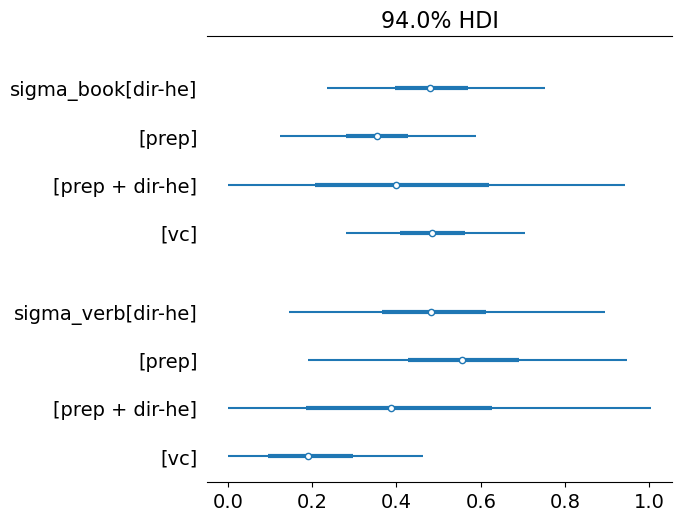

In [46]:
# Check pooling magnitude
az.plot_forest(idata, var_names=["sigma_book","sigma_verb"], combined=True)

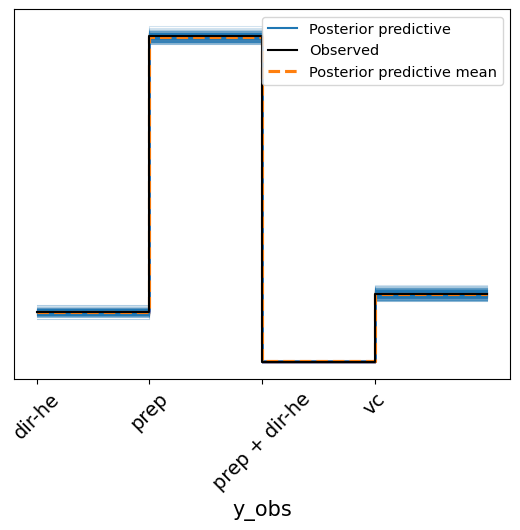

In [47]:
# Posterior predictive check (class frequencies)
az.plot_ppc(ppc, num_pp_samples=200)

plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.show()